# Latent Space Interpolation of Generative Adversarial Networks (DCGAN)

## Karthick Kumaran Ayyalluseshagiri Viswanathan
### IMGS789

### Assignment-2
### Latent Space Interpolation of GAN

In [1]:
!pip install tensorflow~=2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 876.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 36.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


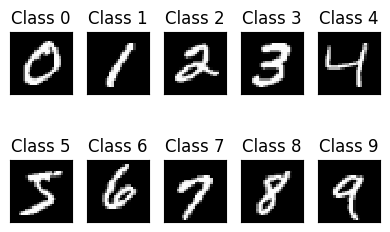

In [4]:
WIDTH_SIZE = 4
HEIGHT_SIZE = 3

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [5]:
print('X_train.shape', X_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)

# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 784)


In [6]:
# latent space dimension
latent_dim = 100

# image dimension 28x28
img_dim = 784

seed_value = 42
initializer = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=seed_value
)

# Generator network
def generator():
  generatormodel = tf.keras.models.Sequential()

  # Input layer and hidden layer 1
  generatormodel.add(
      tf.keras.layers.Dense(
          128, input_shape=(latent_dim,), kernel_initializer=initializer
      )
  )
  generatormodel.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  generatormodel.add(tf.keras.layers.BatchNormalization(momentum=0.8))

  # Hidden layer 2
  generatormodel.add(tf.keras.layers.Dense(256))
  generatormodel.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  generatormodel.add(tf.keras.layers.BatchNormalization(momentum=0.8))

  # Hidden layer 3
  generatormodel.add(tf.keras.layers.Dense(512))
  generatormodel.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  generatormodel.add(tf.keras.layers.BatchNormalization(momentum=0.8))

  # Output layer
  generatormodel.add(tf.keras.layers.Dense(img_dim, activation="tanh"))
  return generatormodel

In [7]:
# prints a summary representation of the generator model
generatormodel = generator()
generatormodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [8]:
# Discriminator network
def discriminator():
  discriminatormodel = tf.keras.models.Sequential()

  # Input layer and hidden layer 1
  discriminatormodel.add(
      tf.keras.layers.Dense(
          128, input_shape=(img_dim,), kernel_initializer=initializer
      )
  )
  discriminatormodel.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  # Hidden layer 2
  discriminatormodel.add(tf.keras.layers.Dense(256))
  discriminatormodel.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  # Hidden layer 3
  discriminatormodel.add(tf.keras.layers.Dense(512))
  discriminatormodel.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  # Output layer
  discriminatormodel.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  return discriminatormodel

In [9]:
# prints a summary representation of the discriminator model
discriminatormodel = discriminator()
discriminatormodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [10]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminatormodel.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

In [11]:
discriminatormodel.trainable = False

# Connect the generator and discriminator
d_g = tf.keras.models.Sequential()
d_g.add(generatormodel)
d_g.add(discriminatormodel)
d_g.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

In [12]:
# prints a summary representation of the GAN model
d_g.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 784)               583312    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 265601    
                                                                 
Total params: 848,913
Trainable params: 581,520
Non-trainable params: 267,393
_________________________________________________________________


epoch = 1/20, d_loss=0.471, g_loss=1.778                                                                                                     
1/1 [==============================] - 0s 23ms/step


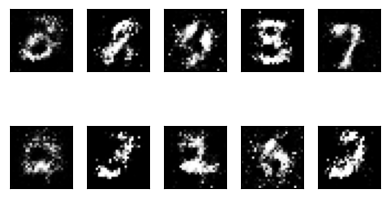

epoch = 2/20, d_loss=0.697, g_loss=1.453                                                                                                     
epoch = 3/20, d_loss=0.510, g_loss=1.398                                                                                                     
epoch = 4/20, d_loss=0.607, g_loss=1.305                                                                                                     
epoch = 5/20, d_loss=0.656, g_loss=1.345                                                                                                     
epoch = 6/20, d_loss=0.482, g_loss=1.407                                                                                                     
epoch = 7/20, d_loss=0.553, g_loss=1.235                                                                                                     
epoch = 8/20, d_loss=0.615, g_loss=1.215                                                                                                     
epoch 

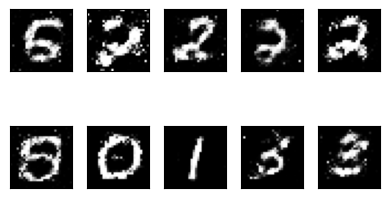

epoch = 12/20, d_loss=0.563, g_loss=1.239                                                                                                     
epoch = 13/20, d_loss=0.550, g_loss=1.176                                                                                                     
epoch = 14/20, d_loss=0.596, g_loss=1.267                                                                                                     
epoch = 15/20, d_loss=0.616, g_loss=1.154                                                                                                     
epoch = 16/20, d_loss=0.545, g_loss=1.143                                                                                                     
epoch = 17/20, d_loss=0.592, g_loss=1.085                                                                                                     
epoch = 18/20, d_loss=0.594, g_loss=1.174                                                                                                     

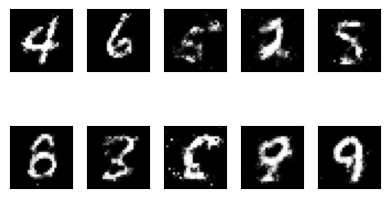

In [14]:
epochs = 20
batch_size = 64
smooth = 0.1

real = tf.ones(shape=(batch_size, 1))
fake = tf.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        # Train Discriminator weights
        discriminatormodel.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        d_loss_real = discriminatormodel.train_on_batch(
            x=X_batch, y=real * (1 - smooth)
        )

        # Fake Samples
        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        X_fake = generatormodel.predict_on_batch(z)
        d_loss_fake = discriminatormodel.train_on_batch(x=X_fake, y=fake)

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminatormodel.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                d_g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], d_g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10

        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        x_fake = generatormodel.predict(z)

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap="gray")
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

1/1 [==============================] - 0s 22ms/step


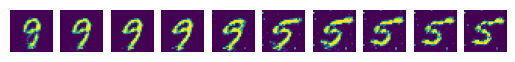

1/1 [==============================] - 0s 28ms/step


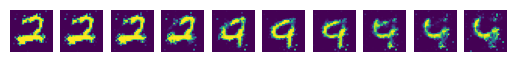

1/1 [==============================] - 0s 30ms/step


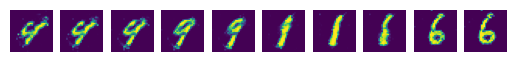

1/1 [==============================] - 0s 27ms/step


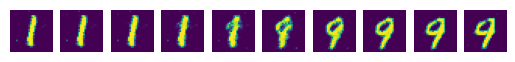

1/1 [==============================] - 0s 37ms/step


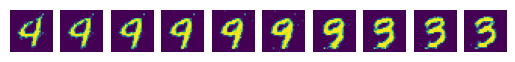

1/1 [==============================] - 0s 30ms/step


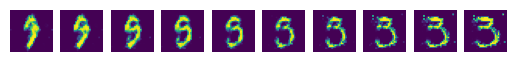

1/1 [==============================] - 0s 34ms/step


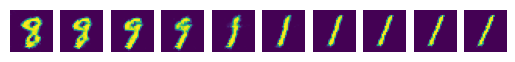

1/1 [==============================] - 0s 28ms/step


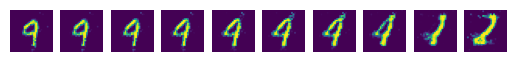

1/1 [==============================] - 0s 36ms/step


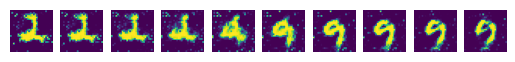

In [40]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
  for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.axis('off')
    img = np.reshape(examples[i, :], (28, 28))
    plt.imshow(img)
  plt.show()

for l in range(1, 10):
  # generate points in latent space
  pts = generate_latent_points(100, 2)
  # interpolate points in latent space
  interpolated = interpolate_points(pts[0], pts[1])
  # generate images
  X = generatormodel.predict(interpolated)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot the result
  plot_generated(X, len(interpolated))